In [1]:
import os, sys
import re
import numpy as np
import pandas as pd
import pickle as pkl
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Parameters
The observations are between 20 January 2020 to 22 February 2020.

Exposed population on 20 Jan 20202 = to be estimated using DXY's data. To a ratio exists between infected and suspected counts

I0 = initial number of infected cases in the world based on known numbers

In [2]:
df = pd.read_csv("../data/daily_time_series_data_JHU.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
case = df.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [3]:
dxy = pd.read_csv("../data/DXYArea.csv")
dxy['date'] = pd.to_datetime(dxy['date'])
dxy = dxy[dxy['date'] > datetime(2019, 12, 7)]  # first day is 2019-12-08
dxy = dxy[dxy['date'] != dxy['date'].max()] # remove todays' records (since it can be incompleted)

dxy['R'] = dxy['cured'] + dxy['dead']
SIR_data = dxy[['date', 'Days', 'countryCode','province', 'city', 'net_confirmed', 'suspected', 'R', 
              ]].rename(columns={"net_confirmed": "I", "suspected": "E"})
China_dxy = SIR_data[SIR_data['date'] < datetime(2020, 2, 14)] 
China_total = China_dxy[(China_dxy['countryCode']=='CN') & (China_dxy['province'].isnull())]
China_total['new infected'] = China_total['I'].diff().fillna(1)

14


2.3988121583669337

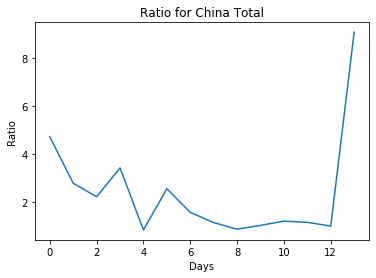

In [4]:
"""
    Find the mean of ratio for China total
    Using the observation two weeks from 2020-01-20 to estimate the ratio
"""
i = -25 # obserbvation after 2020-01-20
ratios = []
n = 7
while(i <=-10):
    I0_diff = list(China_total['I'])[i+n+1] - list(China_total['I'])[i+n]
    E0_6_diff = list(China_total['E'])[i+1] - list(China_total['E'])[i]
    ratio = I0_diff/E0_6_diff

    if ratio >0 and ratio < 10:
        ratios.append(ratio)
    
    i +=1
plt.title("Ratio for China Total")
plt.ylabel("Ratio")
plt.xlabel("Days")
print(len(ratios))
plt.plot(ratios)   
exposed_ratio = np.mean(ratios)
exposed_ratio

In [5]:
N = 7.5e9   # assumption on world's population
I0 = case['Confirmed'].iloc[0]  # Initial number of Recovered cases at the time of data collection
R0 = 0 # Initial number of Recovered cases
E0 = round(I0*exposed_ratio) # initial number of Exposed cases at the time of data collection
S0 = N - E0 - I0 - R0 # initial susceptible population

incubation_duration = 5.2 # based on paper https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
serial_interval = 7.5 # based on paper https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
infectious_duration = serial_interval - incubation_duration

sigma = 1/incubation_duration # incubation rate
gamma = 1/infectious_duration # recovery rate

n_days = 240 # number of days ahead to forecast
t = np.linspace(0, n_days, n_days)

R_0 = 2.2 # base on paper https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
beta = R_0 * gamma 

In [6]:
def deriv(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E 
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [7]:
# Initial conditions vector
y0 = S0, E0, I0, R0
print(y0)

# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, sigma, gamma))
S, E, I, R = ret.T

(7499999511.0, 345.0, 144.0, 0)


In [8]:
date_start = datetime.strptime('2020-01-20', '%Y-%m-%d')
datelist = pd.date_range(date_start,periods=n_days).to_list()
dates = [str(d.date()) for d in datelist]
print(dates[0], dates[-1])
dates = dates[::2]

2020-01-20 2020-09-15


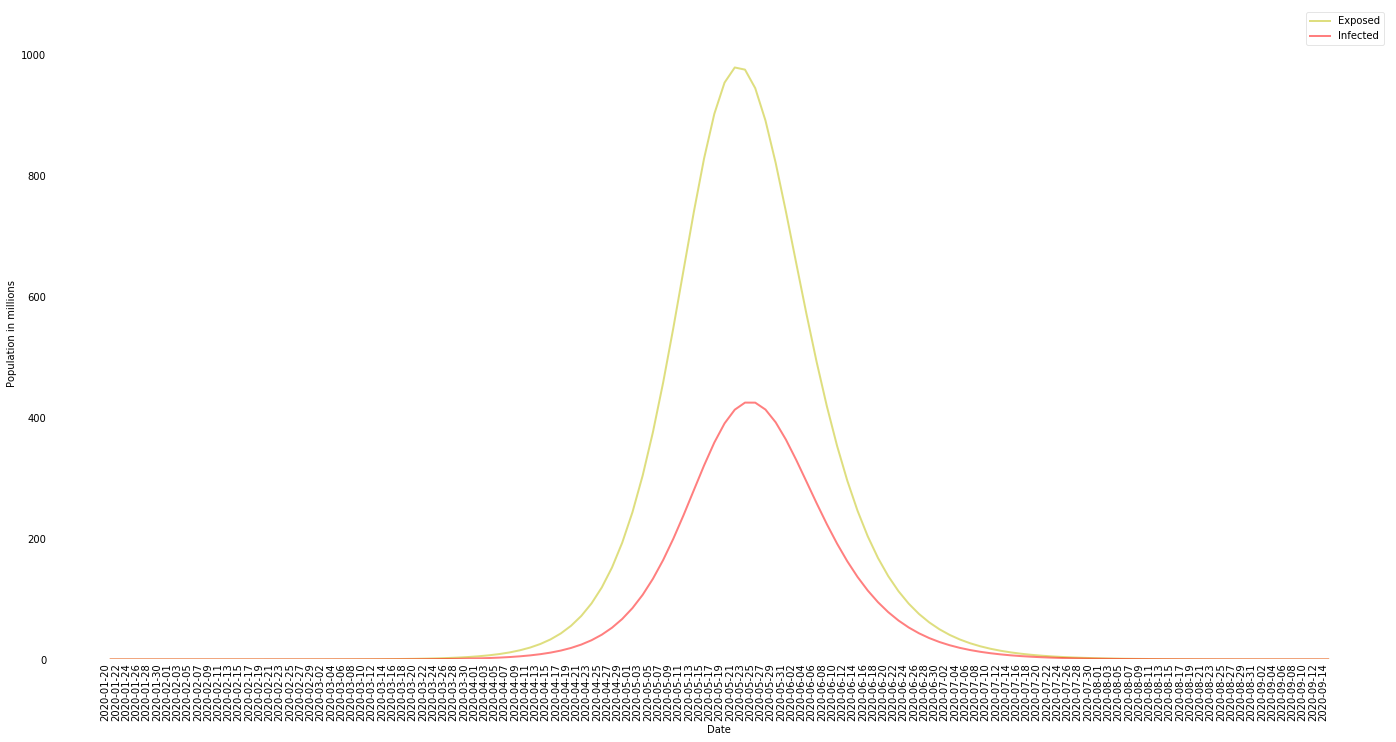

In [14]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(24,12))
ax = fig.add_subplot()

scaling_factor = 1e6
# ax.plot(dates, S[::2]/scaling_factor, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(dates, E[::2]/scaling_factor, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(dates, I[::2]/scaling_factor, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(dates, R[::2]/scaling_factor, 'g', alpha=0.5, lw=2, label='Removed')

# ax.set_xticks(range(n_days),2)
ax.set_xticklabels(dates, rotation = 90, ha="right")
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Date')
ax.set_ylabel(f'Population in millions')
ax.set_ylim(0,E.max()*1.1/scaling_factor)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('Exposed and infection trajectories.png')
plt.show()

In [10]:
graph_values = pd.DataFrame(list(zip(dates, I[::2])))
graph_values.iloc[:,1] = np.ceil(graph_values.iloc[:,1])
graph_values.columns = ['Date', 'Number of Infected People']

In [11]:
max_idx = graph_values['Number of Infected People'].argmax()
graph_values.iloc[max_idx,:]

Date                          2020-05-23
Number of Infected People    4.25066e+08
Name: 62, dtype: object

In [12]:
for g in range(max_idx,len(graph_values)):
    if graph_values['Number of Infected People'].iloc[g] < 1e7:
        print(graph_values['Date'].iloc[g])
        break
for g in range(max_idx,len(graph_values)):
    if graph_values['Number of Infected People'].iloc[g] < 1e6:
        print(graph_values['Date'].iloc[g])
        break
for g in range(max_idx,len(graph_values)):
    if graph_values['Number of Infected People'].iloc[g] < 1e4:
        print(graph_values['Date'].iloc[g])
        break

2020-07-12
2020-08-03
2020-09-14
